In [1]:
import os
import json

output_dir = "/lustre/fsw/portfolios/llmservice/users/sghotra/data/gen/pv_methd/preproc_gsm8k_neg"

The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.


In [2]:
# load data
data_file = "/lustre/fsw/portfolios/llmservice/users/sghotra/data/grade-school-math/grade_school_math/data/train.jsonl"

data = {}
with open(data_file, 'r') as f:
    for i, line in enumerate(f):
        line = json.loads(line.strip())
        line['id'] = i
        data[i] = line

# load gen
gen_data_dir = "/lustre/fsw/portfolios/llmservice/users/sghotra/data/gen/pv_methd/gsm8k_neg_llama31-8b_inst"
gen_data = []
part1_ids = []

for gen_data_file in os.listdir(gen_data_dir):
    gen_data_file = os.path.join(gen_data_dir, gen_data_file)
    with open(gen_data_file, 'r') as f:
        for i, line in enumerate(f):
            line = json.loads(line.strip())
            gen_data.append(line)
            part1_ids.append(line["id"])

part1_ids = set(part1_ids)

gen_data_dir = "/lustre/fsw/portfolios/llmservice/users/sghotra/data/gen/pv_methd/gsm8k_neg_llama31-8b_inst_part2"

for gen_data_file in os.listdir(gen_data_dir):
    gen_data_file = os.path.join(gen_data_dir, gen_data_file)
    with open(gen_data_file, 'r') as f:
        for i, line in enumerate(f):
            line = json.loads(line.strip())
            
            # if line["id"] not in part1_ids:
            gen_data.append(line)


In [3]:
# basic stats of the gen data
# Total number of examples
print("Total number of examples in input: ", len(data))
print("Total number of examples in gen: ", len(gen_data))

Total number of examples in input:  7473
Total number of examples in gen:  119680


In [4]:
# set PYTHONPATH

import sys
sys.path.append("/lustre/fsw/portfolios/llmservice/users/sghotra/code/Adv_Verif_Train/")

from utils.extract_gsm_ans import extract_answer_from_response

# remove None cases from the gen_data
# remove the trailing part of the gen_data (after "The answer is x\n")
filtered_gen_data = []
for i in range(len(gen_data)):
    response = gen_data[i]['response']

    # FIXME: remove it
    response = response.split("Flawed ")[1] if "Flawed " in response else ""

    pred_ans = extract_answer_from_response(response, delimiter="The final answer is ")
    if not isinstance(pred_ans, int):
        continue

    response = response.split("The final answer is")[0] + "The final answer is " + str(pred_ans) + "\n"
    gen_data[i]['response'] = response

    filtered_gen_data.append(gen_data[i])

print("Original gen_data length: ", len(gen_data))
print("Filtered gen_data length: ", len(filtered_gen_data))
gen_data = filtered_gen_data

Original gen_data length:  119680
Filtered gen_data length:  100540


In [5]:
# join based on id
joined_data = []

for line in gen_data:
    id = line['id']
    orig_line = data[id]
    joined_line = {**orig_line, **line}
    joined_data.append(joined_line)

# keep: question, answer from the orig data

In [ ]:
# TODO: add original datapoints as well
# Q: what are the fields

In [6]:

print(joined_data[0])

{'question': 'Ken created a care package to send to his brother, who was away at boarding school.  Ken placed a box on a scale, and then he poured into the box enough jelly beans to bring the weight to 2 pounds.  Then, he added enough brownies to cause the weight to triple.  Next, he added another 2 pounds of jelly beans.  And finally, he added enough gummy worms to double the weight once again.  What was the final weight of the box of goodies, in pounds?', 'answer': 'To the initial 2 pounds of jelly beans, he added enough brownies to cause the weight to triple, bringing the weight to 2*3=<<2*3=6>>6 pounds.\nNext, he added another 2 pounds of jelly beans, bringing the weight to 6+2=<<6+2=8>>8 pounds.\nAnd finally, he added enough gummy worms to double the weight once again, to a final weight of 8*2=<<8*2=16>>16 pounds.\n#### 16', 'id': 7, 'target': 16, 'response': 'Solution:\nStep 1: Initially we added jelly beans, weighing 2 pounds, and brownies of unspecified weight. \nStep 2: The we

Overall frac:  0.05 0.95


Text(0.5, 1.0, 'Gen data label frac histogram')

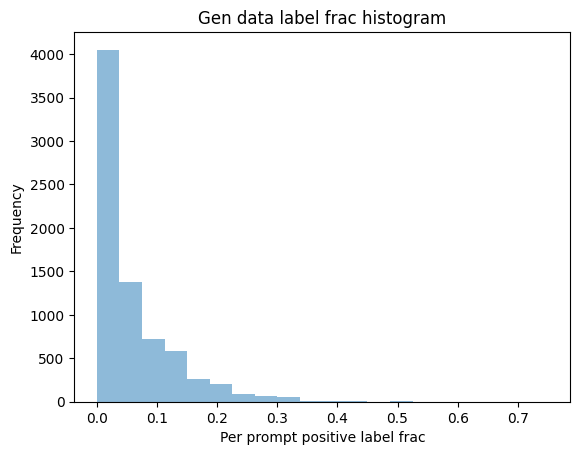

In [7]:
# compute the stats
per_prompt_label_frac = {}

for line in joined_data:
    id = line['id']
    label = line['label']
    if id not in per_prompt_label_frac:
        per_prompt_label_frac[id] = []
        
    per_prompt_label_frac[id].append(label)

pos_labels = 0
total = 0
for id in per_prompt_label_frac:
    pos_labels += sum(per_prompt_label_frac[id])
    total += len(per_prompt_label_frac[id])
    pos_label_frac = sum(per_prompt_label_frac[id]) / len(per_prompt_label_frac[id])
    per_prompt_label_frac[id] = [pos_label_frac, 1 - pos_label_frac]

# overall frac
print("Overall frac: ", round(pos_labels / total, 2), round(1 - (pos_labels / total), 2))

# per prompt label frac histogram

import matplotlib.pyplot as plt
import numpy as np

pos_label_fracs = [per_prompt_label_frac[id][0] for id in per_prompt_label_frac]
neg_label_fracs = [per_prompt_label_frac[id][1] for id in per_prompt_label_frac]

# labels fracs are b/w 0 and 1
plt.hist(pos_label_fracs, bins=20, alpha=0.5, label='pos label fracs')
plt.xlabel('Per prompt positive label frac')
plt.ylabel('Frequency')
plt.title('Gen data label frac histogram')


In [8]:
# ORM training format
# text (query: from orig data + response: from gen data) and label

out_data = []
for line in joined_data:
    query = line['question']
    text = query + " " + response
    out = {"text": text, **line}

    out_data.append(out)

In [9]:
print(out_data[0])

{'text': 'Ken created a care package to send to his brother, who was away at boarding school.  Ken placed a box on a scale, and then he poured into the box enough jelly beans to bring the weight to 2 pounds.  Then, he added enough brownies to cause the weight to triple.  Next, he added another 2 pounds of jelly beans.  And finally, he added enough gummy worms to double the weight once again.  What was the final weight of the box of goodies, in pounds? Solution:\nStep 1: Yesterday Julie read 12 pages and she read the same amount in total on the remaining days from today onwards, so she read 12 + (12 + 12 + 12) = 48 pages today and in total for the remaining days.\nStep 2: Total pages read is 12 (yesterday) + 48 = 60.\nStep 3: She started with 120 pages, so she has 120 - 60 = 60 pages left (this already has this amount reduced due to todays reading).\nStep 4: However todays work counted pages remaining to todays reading of  48 pages, though pages read  in future dont.\nStep 4b: It was st

In [10]:
# group the data based on ID and random sample 10 groups

import random

grouped_data = {}
for line in joined_data:
    id = line['id']
    if id not in grouped_data:
        grouped_data[id] = []
    response = line['response']
    grouped_data[id].append(response)

list_grouped_data = list(grouped_data.values())
random.shuffle(list_grouped_data)
rand_10 = list_grouped_data[:100]





In [12]:
i = 8
for res in rand_10[i]:
    print(res)
    print("=======")
print()


Solution:
Step 1: Each fourth-grade class has 30 students. Multiplying this by the 3 classes, we have a total of 30 * 3 = 90 students.
Step 2: There's also the P.E. class of 50 students, but let's add this to 0 since there's no other numbers to add it to in the same statement. So the total students is 90 (fourth grade) + 50 = 140. Also for some reason the kids for the fourth-grade students for this part are not being  counted this time.
The final answer is 140

Solution:
Step 1: Jessa has to make cupcakes for 3 classes as well as the P.E. class, which adds up to 3 + 50 = 53.
Step 2: Each of her classes have 30 students. So for those 3 classes alone she will need 53 * 30 = 1590.
The final answer is 1590

Solution:
Step 1: There's one P.E. class with 50 students and a single fourth-grade class with 30 students, so the total number of students in the fourth-grade classes is 50.
Step 2: Since there are actually 4 classes (3 fourth-grade classes), the total number of students in fourth-grad

In [13]:

from fuzzywuzzy import fuzz

# Function to perform fuzzy matching between two strings
def fuzzy_match(string1, string2):
    # Compute the similarity ratio between the two strings
    ratio = fuzz.ratio(string1, string2)
    return ratio

sim_count = 0
for group in rand_10:
    for i in range(len(group)):
        for j in range(i+1, len(group)):
            similarity_ratio = fuzzy_match(group[i], group[j])
            # print(f"Similarity ratio: {similarity_ratio}%")
            if similarity_ratio > 80:
                # print("Similarity ratio: ", similarity_ratio)
                # print(group[i])
                # print(group[j])
                # print("--------")
                sim_count += 1
    print("=====================================")

print("Total similar pairs: ", sim_count)

/lustre/fsw/portfolios/llmservice/users/sghotra/installs/miniforge3/envs/adv_verif/lib/python3.10/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


Total similar pairs:  12


In [14]:
# file format
from datasets import Dataset

# out_data[0] = {"text": "blah", "label": 1}
output_dir_full = "/lustre/fsw/portfolios/llmservice/users/sghotra/data/gen/pv_methd/preproc_gsm8k_neg/full"
data_dict = {key: [d[key] for d in out_data] for key in out_data[0]}
dataset = Dataset.from_dict(data_dict)
dataset.save_to_disk(output_dir_full)

/lustre/fsw/portfolios/llmservice/users/sghotra/installs/miniforge3/envs/adv_verif/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Saving the dataset (1/1 shards): 100%|██████████| 100540/100540 [00:00<00:00, 510986.05 examples/s]


In [17]:
# shuffle
import random
random.seed(8472)
random.shuffle(out_data)
half_out_data = out_data[:len(out_data) // 2]

output_dir_half = "/lustre/fsw/portfolios/llmservice/users/sghotra/data/gen/pv_methd/preproc_gsm8k_neg/half"
data_dict = {key: [d[key] for d in half_out_data] for key in half_out_data[0]}
dataset = Dataset.from_dict(data_dict)
dataset.save_to_disk(output_dir_half)

Saving the dataset (1/1 shards): 100%|██████████| 28016/28016 [00:00<00:00, 632155.65 examples/s]


In [ ]:
# for later: Deduplication

#### BKP code

In [ ]:
# group the data based on ID and random sample 10 groups

import random

grouped_data = {}
for line in joined_data:
    id = line['id']
    if id not in grouped_data:
        grouped_data[id] = []
    response = line['response']
    grouped_data[id].append(response)

# grouped_data = list(grouped_data.values())
# random.shuffle(grouped_data)
rand_10 = grouped_data[:100]


i = 2
for res in rand_10[i]:
    print(res)
    print("=======")
print()


from fuzzywuzzy import fuzz

# Function to perform fuzzy matching between two strings
def fuzzy_match(string1, string2):
    # Compute the similarity ratio between the two strings
    ratio = fuzz.ratio(string1, string2)
    return ratio

sim_count = 0
for group in rand_10:
    for i in range(len(group)):
        for j in range(i+1, len(group)):
            similarity_ratio = fuzzy_match(group[i], group[j])
            # print(f"Similarity ratio: {similarity_ratio}%")
            if similarity_ratio > 80:
                # print("Similarity ratio: ", similarity_ratio)
                # print(group[i])
                # print(group[j])
                # print("--------")
                sim_count += 1
    print("=====================================")

print("Total similar pairs: ", sim_count)